In [25]:
# Clustering Example 4 with K-Means ++ Implementation
# Dataset: Breast Cancer dataset
#
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
import statsmodels as stats
from numpy import linalg as lin

from scipy.spatial.distance import mahalanobis

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import adjusted_rand_score

from sklearn.preprocessing import StandardScaler

import pdb
import time

In [26]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Vector-to-Vector Similarity Measures
#
def mahalanob_dist(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    nrows = a.shape[0]
    mean_dev = (a - b).T
    inv_covmat_mult_mean_dev = lin.solve(cov_mat, mean_dev)
    maha_dist_sq = np.zeros((nrows,1))
    for mm in range(0,nrows):
      maha_dist_sq[mm] = np.dot(mean_dev[:,mm], inv_covmat_mult_mean_dev[:,mm])
    maha_dist = np.sqrt(maha_dist_sq)
    return maha_dist.flatten()


def mahalanobis_distance(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    mean_dev = a - b
    inv_cov_mat = np.linalg.inv(cov_mat)
    maha_dist_sq = np.dot(np.dot(mean_dev, inv_cov_mat), mean_dev.T)
    maha_dist_sq = np.diag(maha_dist_sq)
    maha_dist = np.sqrt(maha_dist_sq)
    return maha_dist

def scipy_mahala(a, b, cov_mat):
    # a is an m by n matrix, b is a 1 by n vector and cov_mat is a covariance matrix
    # from scipy.spatial.distance import mahalanobis
    nrows = a.shape[0]
    inv_cov_mat = lin.inv(cov_mat)
    mm = 0
    maha_dist = np.zeros((nrows,))
    for vec in a:
      maha_dist[mm] = mahalanobis(vec, b, inv_cov_mat)
      mm += 1
    return maha_dist

def cos_sim(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    ab_inner = np.inner(a,b)
    anorm = lin.vector_norm(a, axis = 1)
    bnorm = lin.vector_norm(b)
    sim_cos = ( ab_inner / (anorm * bnorm) )
    return sim_cos


def cos_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    cossim = cos_sim(a,b)
    dist_cos = 1 - cossim
    return dist_cos


def dot_prod_sim(a,b):
    sim_dot = np.inner(a,b)
    return sim_dot


def udp_sim(a,b):
    ab_inner = np.inner(a,b)
    anorm = lin.vector_norm(a, axis = 1)
    bnorm = lin.vector_norm(b)
    apb_norm = anorm + bnorm
    sim_udp = ab_inner / (apb_norm ** 2)
    return sim_udp


def city_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    d_city = np.sum(np.abs(a-b), axis = 1)
    return d_city


def euc_dist(a,b):
    # a is an m by n matrix and b is a 1 by n vector
    d_euc = np.sqrt( np.sum((a-b)**2, axis = 1) )
    return d_euc


def city_cos_dist(a, b, vphi):
    # a is an m by n matrix and b is a 1 by n vector
    # vphi = 3
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    d_cit = city_dist(a, b)
    #
    d_cit_cos = d_cit * np.abs(cos_theta - vphi)
    return d_cit_cos


def city_cos_sim(a, b, vphi):
    d_cit_cos = city_cos_dist(a, b, vphi)
    sim_cit_cos = 1 / d_cit_cos
    # sim_cit_cos = 1 / (1 + d_cit_cos)
    return sim_cit_cos


def euc_cos_dist(a, b, vphi):
    # a is an m by n matrix and b is a 1 by n vector
    # vphi = 7
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    # a_b_sq = anorm_sq - 2*ab_inner + bnorm_sq
    # d_euc = np.sqrt( a_b_sq )
    d_euc = euc_dist(a,b)
    #
    d_euc_cos = d_euc * np.abs(cos_theta - vphi)
    return d_euc_cos


def euc_cos_sim(a, b, vphi):
    d_euc_cos = euc_cos_dist(a, b, vphi)
    sim_euc_cos = 1 / d_euc_cos
    # sim_euc_cos = 1 / (1 + d_euc_cos)
    return sim_euc_cos


def mink_dist(a, b, p):
    # a is an m by n matrix and b is a 1 by n vector
    d_mink = np.power( np.sum(np.power(np.abs(a-b), p), axis = 1), 1/p )
    return d_mink


def mink_cos_dist(a, b, vphi, p):
    # a is an m by n matrix and b is a 1 by n vector
    ab_inner = np.inner(a,b)
    anorm_sq = np.sum(a**2, axis = 1)
    bnorm_sq = np.sum(b**2)
    #
    anorm = np.sqrt(anorm_sq)
    bnorm = np.sqrt(bnorm_sq)
    #
    cos_theta = ab_inner / (anorm * bnorm)
    #
    d_mink = mink_dist(a, b, p)
    #
    d_mink_cos = d_mink * np.abs(cos_theta - vphi)
    return d_mink_cos


def mink_cos_sim(a, b, vphi, p):
    d_mink_cos = mink_cos_dist(a, b, vphi, p)
    sim_mink_cos = 1 / (1 + d_mink_cos)
    return sim_mink_cos

In [27]:
# Code provided by google AI Assistant
import numpy as np

def get_dominant_eigenvector(matrix):
  """
  Calculates the dominant eigenvector of a square matrix.

  Args:
    matrix: A NumPy array representing the square matrix.

  Returns:
    A NumPy array representing the dominant eigenvector, or None if the input is invalid.
  """
  try:
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))
    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    return dominant_eigenvector
  except np.linalg.LinAlgError:
      print("Input is not a square matrix or other error occurred")
      return None


In [28]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# The Breast Cancer Wisconsin dataset has 569 samples of breast cancer biopsies, each with 30 features about the cell
# nuclei characteristics. The samples are either malignant or benign.

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target

display(cancer_df.sample(7))


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.71190,0.26540,0.4601,0.11890,0
514,15.050,19.07,97.26,701.9,0.09215,0.08597,0.07486,0.04335,0.1561,0.05915,...,28.06,113.80,967.0,0.1246,0.2101,0.28660,0.11200,0.2282,0.06954,0
355,12.560,19.07,81.92,485.8,0.08760,0.10380,0.10300,0.04391,0.1533,0.06184,...,22.43,89.02,547.4,0.1096,0.2002,0.23880,0.09265,0.2121,0.07188,1
23,21.160,23.04,137.20,1404.0,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,...,35.59,188.00,2615.0,0.1401,0.2600,0.31550,0.20090,0.2822,0.07526,0
385,14.600,23.29,93.97,664.7,0.08682,0.06636,0.08390,0.05271,0.1627,0.05416,...,31.71,102.20,758.2,0.1312,0.1581,0.26750,0.13590,0.2477,0.06836,0
273,9.742,15.67,61.50,289.9,0.09037,0.04689,0.01103,0.01407,0.2081,0.06312,...,20.88,68.09,355.2,0.1467,0.0937,0.04043,0.05159,0.2841,0.08175,1
111,12.630,20.76,82.15,480.4,0.09933,0.12090,0.10650,0.06021,0.1735,0.07070,...,25.47,89.00,527.4,0.1287,0.2250,0.22160,0.11050,0.2226,0.08486,1


In [29]:
unique_names_count = cancer_df['target'].nunique()
print(unique_names_count)
n_clusters = unique_names_count

2


In [30]:
x = cancer_df.drop(columns = ['target'])

# Cluster index
y = cancer_df['target']

In [31]:
# Standardize the features
scaler = StandardScaler()
x_sca = scaler.fit_transform(x)

In [32]:
# Select between original data and normalized data

# # 1. Original data
df_data = x.copy()

# 2. Normalized data
# cols = x.columns
# df_data = pd.DataFrame(x_sca.copy(), columns = cols)

# # display(df_data.head())

In [33]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
def initialize_centroids(data, k, sim_meas, vphi_city = None, vphi_euc = None, vphi_mink = None, pval = None):
  nrows, ncols = data.shape
  #
  centroids = np.zeros( (k,ncols) )
  random_pick = np.random.randint(0,nrows)
  centroids[0,:] = data[random_pick,:]
  #
  centroids_0 = centroids[0:1,:]
  # plot(data, np.array(centroids_0))
  #
  dist = np.zeros((nrows,k))
  for i in range(k - 1):
      #
      for j, centro in enumerate(centroids[0:i+1, :]):
          if sim_meas == city_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_city)
          elif sim_meas == euc_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_euc)
          elif sim_meas == mink_cos_dist:
            dist[:, j] = sim_meas(data, centro, vphi_mink, pval)
          elif sim_meas == mahalanob_dist or sim_meas == mahalanobis_distance or sim_meas == scipy_mahala:
            # cov_mat = np.identity(ncols, dtype="int")
            # dist[:, j] = sim_meas(data, centro, cov_mat)
            dist[:,j] = euc_dist(data, centro)
          else:
            dist[:, j] = sim_meas(data, centro)
      #
      min_dist = np.min(dist[:,0:j+1], axis = 1)
      centroids[i+1, :] = data[np.argmax(min_dist)]

      centroids_i = centroids[0:i+2,:]
      # pdb.set_trace()

  return np.array(centroids)


In [34]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
def kmeans(df_clust, k, max_iter, sim_meas, vphi_city = None, vphi_euc = None, vphi_mink = None, pval = None):
  # Convert from dataframe obj to numpy object
  dat = df_clust.to_numpy()
  # dat = df_clust.values # this can also be used to covert to a numpy array
  #
  nrows, ncols = dat.shape
  if sim_meas == mahalanob_dist or sim_meas == mahalanobis_distance or sim_meas == scipy_mahala:
      cov_mats = np.zeros((k, ncols, ncols))
      for nn in range(k):
          cov_mat = np.identity(ncols, dtype="int")
          cov_mats[nn, :, :] = cov_mat
      #
  #
  # Find the initial centroids using KMeans++ algorithm
  init_centroids = initialize_centroids(dat, k, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
  centroids = init_centroids.copy()
  last_valid_centroids = centroids.copy()
  #
  # Run the while loop of the KMeans to cluster the data
  tol = 1e-300
  chge = 10
  # max_iter = 100
  iter = 0
  while iter < (max_iter + 1) and tol < chge:
    iter = iter + 1
    #
    dist = np.zeros((nrows,k))
    dats = dat[:, :ncols]
    #
    # Pick each centroid and find the distances between all datapoints and each centroid
    for j in range(k):
      if sim_meas == city_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_city)
      elif sim_meas == euc_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_euc)
      elif sim_meas == mink_cos_dist:
        dist[:, j] = sim_meas(dats, centroids[j,:], vphi_mink, pval)
      elif sim_meas == mahalanob_dist or sim_meas == mahalanobis_distance or sim_meas == scipy_mahala:
        cov_mat = cov_mats[j, :, :]
        dist[:, j] = sim_meas(dats, centroids[j,:], cov_mat)
      else:
        dist[:, j] = sim_meas(dats, centroids[j,:])
    pred_clust = np.argmin(dist, axis = 1)
    df_clust['pred_clust'] = np.argmin(dist, axis = 1)
    #
    # Group by 'cluster' and calculate the mean of other columns
    new_centroids_df = df_clust.groupby('pred_clust').mean().iloc[:, :ncols]
    #
    new_centroids = new_centroids_df.values
    n1, n2 = new_centroids.shape
    # pdb.set_trace()
    if n1 != k:
      centroids = last_valid_centroids.copy()
      df_clust = last_df_clust.copy()
      print('number of clusters is incorrect')
      print('Predicted No. of clusters:', n1)
      print('Actual No. of clusters:', k)
      print('last_valid_centroids:\n', centroids)
      print('KMeans terminating for the distance measure ... ', sim_meas)
      chge = 0
      break
      # return (df_clust, centroids)
    else:
      chge = np.sum( np.abs( new_centroids - centroids ) )
      centroids = new_centroids.copy()
      last_valid_centroids = centroids.copy()
      last_df_clust = df_clust.copy()
  #
    #
    if sim_meas == mahalanob_dist or sim_meas == scipy_mahala:
      grouped = df_clust.groupby('pred_clust')
      cov_mats = np.zeros((k, ncols, ncols))
      for id, group_df in grouped:
        grp_j = group_df.iloc[:, :ncols]
        cov_mat = grp_j.cov().values
        cov_mats[id, :, :] = cov_mat
      #
  # return the clustered data and centroids
  return (df_clust, centroids, iter)


In [35]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Function to Compute the Accuracy
def get_accuracy(df_clust):
  #
  list_df_clust = []
  correct_predictions = 0

  for i in range(k):
    # Select rows where 'pred_clust' is equal to i
    clust_i = df_clust[df_clust['pred_clust'] == i]
    mode_value = clust_i['actual_clust'].mode()[0]
    mode_count = clust_i['actual_clust'].value_counts()[mode_value]
    correct_predictions += mode_count

    clust_i.loc[:, 'pred_clust'] = mode_value
    list_df_clust.append(clust_i)

  # Calculate the accuracy
  accuracy = correct_predictions / len(df_clust)

  # Concat the df_clust
  df_clustered = pd.concat(list_df_clust, ignore_index=True)

  return (accuracy, df_clustered)


In [36]:
# Set the random seeds for reproducibility and fair comparisons
rseeds = [121, 7643, 938, 28520, 2302, 17484, 8006, 893245, 377, 873469, 28283, 28941, 93989, 65387, 7365, 3957]
n_trials = 15 # len(rseeds)

# data = df_clust.to_numpy()
# data = df_clust.values # this is also a numpy array

# Create a dictionary of similarity measures
# key: similarity measures
# mahalanobis(a, b, inv_cov_mat)

measures = {
    1: cos_dist,
    2: city_dist,
    3: euc_dist,
    4: city_cos_dist,
    5: euc_cos_dist
}

# measures = {
#     1: mahalanob_dist,
#     2: cos_dist,
#     3: city_dist,
#     4: euc_dist,
#     5: city_cos_dist,
#     6: euc_cos_dist
# }

# measures = {
#     1: mahalanobis_distance,
#     2: cos_dist,
#     3: city_dist,
#     4: euc_dist,
#     5: city_cos_dist,
#     6: euc_cos_dist
# }

# measures = {
#     1: scipy_mahala,
#     2: cos_dist,
#     3: city_dist,
#     4: euc_dist,
#     5: city_cos_dist,
#     6: euc_cos_dist
# }

n_meas = len(measures)


In [37]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(n_meas)]

# Create a 2-dimensional list to store the cntroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(n_meas)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (n_meas, n_trials) )
adj_rand_scores = np.zeros( (n_meas, n_trials) )
n_iters = np.zeros( (n_meas, n_trials) )
elapsed_time = np.zeros( (n_meas,) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# Set the values of vphi
vphi_city = 1.0
vphi_euc = 1.0
# These are optimal for original data

# Uncomment this if the data is transformed into standard normal scores
# vphi_city = 1.7 # 0.55
# vphi_euc = 2.35 # 0.65
# These are optimal for sgd transformed data

# Loop over the sim measures
for key in measures:
  sim_meas = measures[key]
  print(f'Similarity Measure: {sim_meas}')
  #
  start_time = time.time()
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, iters = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[key-1][nt] = accur
    centroids_list[key-1][nt] = centroids
    df_clustered_list[key-1][nt] = ordered_clust
    adj_rand_scores[key-1][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
    n_iters[key-1][nt] = iters
  end_time = time.time()
  elapsed_time[key-1] = end_time - start_time
#
sum_n_iters = np.sum(n_iters, axis = 1)
print('No. of iters:\n', sum_n_iters)
print()
print('Elapsed Time:\n', elapsed_time)
print()

# display(ordered_clust)
# print()

cols = ['Cos', 'City', 'Euc', 'JDM 1', 'JDM 2']
# cols = ['Mahalanobis', 'Cos', 'City', 'Euc', 'JDM 1', 'JDM 2']

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# print('Accuracies:\n')
# display(df_accuracies)
print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# print('Adjusted Rand Score:\n')
# display(df_adj_rand_scores)
print()

df_accuracies_stat = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat)
print()

# Save file to desktop
# df_accuracies_stat.to_csv('df_accuracies_stat.txt', sep='\t', index=True)
df_accuracies_stat.to_csv('df_accuracies_stat_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution

df_adj_rand_scores_stat = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat)
print()

# Save file to desktop
# df_adj_rand_scores_stat.to_csv('df_adj_rand_scores_stat.txt', sep='\t', index=True)
df_adj_rand_scores_stat.to_csv('df_adj_rand_scores_stat_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution

# df_accuracies.plot
# print()

# display(df_accuracies.mean(axis = 1))
# print()
# display(df_adj_rand_scores.mean(axis = 1))

# print('Elapsed Time:\n', elapsed_time)
# pdb.set_trace()

Similarity Measure: <function cos_dist at 0x7979cf843560>
Similarity Measure: <function city_dist at 0x7979cf843240>
Similarity Measure: <function euc_dist at 0x7979cf843880>
Similarity Measure: <function city_cos_dist at 0x7979cf8434c0>
Similarity Measure: <function euc_cos_dist at 0x7979cf8680e0>
No. of iters:
 [134. 177. 168. 124. 123.]

Elapsed Time:
 [0.30811548 0.33156967 0.32230997 0.28411651 0.28232646]



Stats of Accuracy:



,Cos,City,Euc,JDM 1,JDM 2
count,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.8383,0.8506,0.8541,0.8663,0.8690
std,0.0109,0.0000,0.0000,0.0122,0.0130
min,0.8330,0.8506,0.8541,0.8594,0.8629
25%,0.8330,0.8506,0.8541,0.8594,0.8629
50%,0.8330,0.8506,0.8541,0.8594,0.8629
75%,0.8330,0.8506,0.8541,0.8647,0.8629
max,0.8594,0.8506,0.8541,0.8981,0.8981



Stats of Adjusted Rand Score:



,Cos,City,Euc,JDM 1,JDM 2
count,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.4461,0.4811,0.4914,0.5285,0.5368
std,0.0317,0.0000,0.0000,0.0379,0.0408
min,0.4308,0.4811,0.4914,0.5071,0.5177
25%,0.4308,0.4811,0.4914,0.5071,0.5177
50%,0.4308,0.4811,0.4914,0.5071,0.5177
75%,0.4308,0.4811,0.4914,0.5231,0.5177
max,0.5074,0.4811,0.4914,0.6284,0.6284


In [38]:
# Run the KMeans++ using the similarity measures named in the dictionary

# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# np.random.seed(rseeds[1])
np.random.seed(1)

# array of vphi values:
# city_vphis = np.arange(1.0, 2.0, 0.05).round(2)

city_vphis = np.arange(0.05, 5.05, 0.05).round(2)
euc_vphis = np.arange(0.05, 5.05, 0.05).round(2)

# city_vphis = np.arange(0.05, 1.15, 0.05).round(2)
# euc_vphis = np.arange(0.05, 1.15, 0.05).round(2)

len_vphis = len(city_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_vphis, n_trials) )
adj_rand_scores = np.zeros( (len_vphis, n_trials) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# Set the values of vphi
# vphi_city = 2
vphi_euc = 7

mm = 0
sim_meas = city_cos_dist
# Loop over the sim measures
for vphi_city in city_vphis:
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[mm][nt] = accur
    centroids_list[mm][nt] = centroids
    df_clustered_list[mm][nt] = ordered_clust
    adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
  #
  mm += 1

#
# display(ordered_clust)
# print()

cols = city_vphis

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# display(df_accuracies)
# print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# display(df_adj_rand_scores)
# print()

df_accuracies_stat_jdm1 = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat_jdm1)
print()

# Save file to desktop
# df_accuracies_stat_jdm1.to_csv('df_accuracies_stat_jdm1_vphiv.txt', sep='\t', index=True)
df_accuracies_stat_jdm1.to_csv('df_accuracies_stat_jdm1_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

df_adj_rand_scores_stat_jdm1 = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat_jdm1)
print()

# Save file to desktop
# df_adj_rand_scores_stat_jdm1.to_csv('df_adj_rand_scores_stat_jdm1_vphiv.txt', sep='\t', index=True)
df_adj_rand_scores_stat_jdm1.to_csv('df_adj_rand_scores_stat_jdm1_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

# Plot the accuracies

# df_accuracies.plot
# print()

Stats of Accuracy:



,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506
std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
min,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506
25%,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506
50%,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506
75%,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506
max,0.8506,0.8506,0.8506,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,0.8418,...,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506,0.8506



Stats of Adjusted Rand Score:



,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811
std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
min,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811
25%,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811
50%,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811
75%,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811
max,0.4811,0.4811,0.4811,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,0.4555,...,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811,0.4811


In [39]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# array of vphi values:
# city_vphis = np.arange(1.05, 2.0, 0.05).round(2)

city_vphis = np.arange(0.05, 5.05, 0.05).round(2)
euc_vphis = np.arange(0.05, 5.05, 0.05).round(2)

# city_vphis = np.arange(0.05, 1.15, 0.05).round(2)
# euc_vphis = np.arange(0.05, 1.15, 0.05).round(2)

len_vphis = len(euc_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_vphis)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_vphis, n_trials) )
adj_rand_scores = np.zeros( (len_vphis, n_trials) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# Set the values of vphi
# vphi_city = 2
vphi_euc = 7

mm = 0
sim_meas = euc_cos_dist
# Loop over the sim measures
for vphi_euc in euc_vphis:
  # Loop over the random seeds
  np.random.seed(1)
  for nt in np.arange(n_trials):
    #
    # Set the seed for reproducibility
    # np.random.seed(rseeds[nt])

    # Create acopy of the dataframe
    df_data_copy = df_data.copy()
    # Run the KMeans++ algorithm
    df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc)
    #
    # Get the accuracy and the re-ordered clustered
    df_clustered['actual_clust'] = y
    accur, ordered_clust = get_accuracy(df_clustered)

    accuracies[mm][nt] = accur
    centroids_list[mm][nt] = centroids
    df_clustered_list[mm][nt] = ordered_clust
    adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
  #
  mm += 1

#
# display(ordered_clust)
# print()

cols = euc_vphis

df_accuracies = pd.DataFrame(accuracies.T, index = rseeds[:n_trials], columns = cols)
# display(df_accuracies)
# print()

df_adj_rand_scores = pd.DataFrame(adj_rand_scores.T, index = rseeds[:n_trials], columns = cols)
# display(df_adj_rand_scores)
# print()

df_accuracies_stat_jdm2 = df_accuracies.describe().round(4)
print('Stats of Accuracy:\n')
display(df_accuracies_stat_jdm2)
print()

# Save file to desktop
# df_accuracies_stat_jdm2.to_csv('df_accuracies_stat_jdm2_vphiv.txt', sep='\t', index=True)
df_accuracies_stat_jdm2.to_csv('df_accuracies_stat_jdm2_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

df_adj_rand_scores_stat_jdm2 = df_adj_rand_scores.describe().round(4)
print('Stats of Adjusted Rand Score:\n')
display(df_adj_rand_scores_stat_jdm2)
print()

# Save file to desktop
# df_adj_rand_scores_stat_jdm2.to_csv('df_adj_rand_scores_stat_jdm2_vphiv.txt', sep='\t', index=True)
df_adj_rand_scores_stat_jdm2.to_csv('df_adj_rand_scores_stat_jdm2_vphiv_sgd.txt', sep='\t', index=True)
# sgd indicates standard Gaussian distribution
# vphiv indicates variables values of vphi

# df_accuracies.plot
# print()

# display(df_accuracies.mean(axis = 1))
# print()
# display(df_adj_rand_scores.mean(axis = 1))


Stats of Accuracy:



,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541
std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
min,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541
25%,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541
50%,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541
75%,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541
max,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,0.8524,...,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541,0.8541



Stats of Adjusted Rand Score:



,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,...,4.55,4.60,4.65,4.70,4.75,4.80,4.85,4.90,4.95,5.00
count,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,...,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000,15.0000
mean,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914
std,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
min,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914
25%,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914
50%,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914
75%,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914
max,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,0.4862,...,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914,0.4914


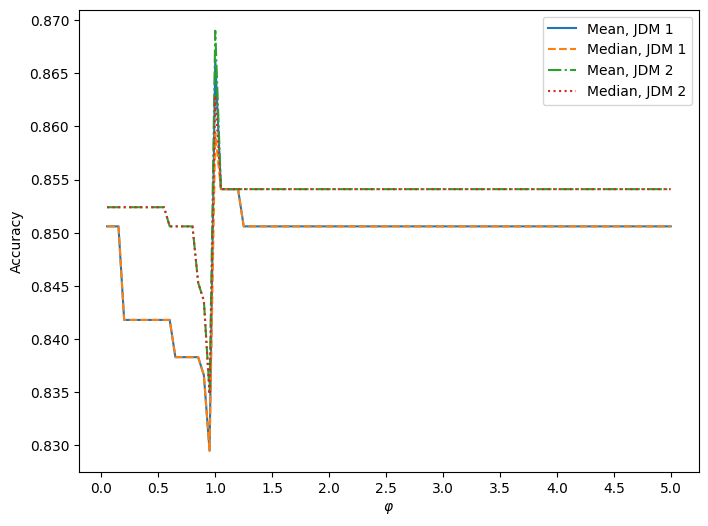

In [40]:
# Create the line plot of Accuracy
vphis_jdm1 = df_accuracies_stat_jdm1.columns
means_jdm1 = df_accuracies_stat_jdm1.loc['mean']
medians_jdm1 = df_accuracies_stat_jdm1.loc['50%']

vphis_jdm2 = df_accuracies_stat_jdm2.columns
means_jdm2 = df_accuracies_stat_jdm2.loc['mean']
medians_jdm2 = df_accuracies_stat_jdm2.loc['50%']

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = vphis_jdm1, y = means_jdm1, label = 'Mean, JDM 1', ax = ax3)
sns.lineplot(x = vphis_jdm1, y = medians_jdm1, label = 'Median, JDM 1', linestyle="--", ax = ax3)
sns.lineplot(x = vphis_jdm2, y = means_jdm2, label = 'Mean, JDM 2', linestyle="-.", ax = ax3)
sns.lineplot(x = vphis_jdm2, y = medians_jdm2, label = 'Median, JDM 2', linestyle=":", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$\varphi$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

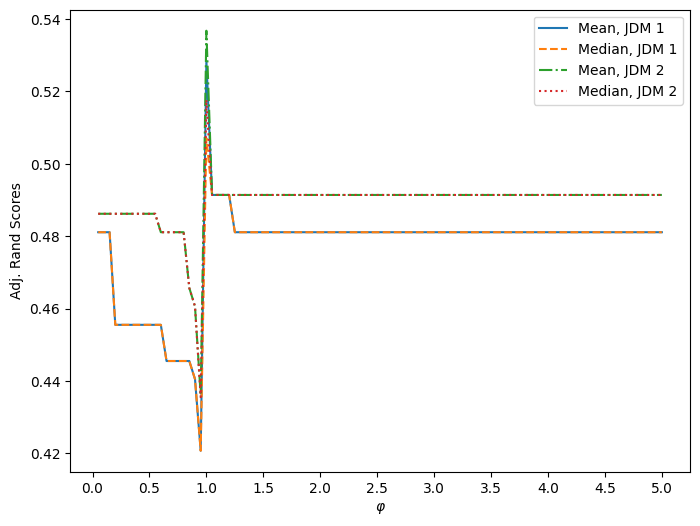

In [41]:
# Create the line plot of Adjusted Rand Scores
vphis_jdm1 = df_adj_rand_scores_stat_jdm1.columns
means_jdm1 = df_adj_rand_scores_stat_jdm1.loc['mean']
medians_jdm1 = df_adj_rand_scores_stat_jdm1.loc['50%']

vphis_jdm2 = df_adj_rand_scores_stat_jdm2.columns
means_jdm2 = df_adj_rand_scores_stat_jdm2.loc['mean']
medians_jdm2 = df_adj_rand_scores_stat_jdm2.loc['50%']

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax4 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = vphis_jdm1, y = means_jdm1, label = 'Mean, JDM 1', ax = ax4)
sns.lineplot(x = vphis_jdm1, y = medians_jdm1, label = 'Median, JDM 1', linestyle="--", ax = ax4)
sns.lineplot(x = vphis_jdm2, y = means_jdm2, label = 'Mean, JDM 2', linestyle="-.", ax = ax4)
sns.lineplot(x = vphis_jdm2, y = medians_jdm2, label = 'Median, JDM 2', linestyle=":", ax = ax4)

# Add labels and title
ax4.set_xlabel(r'$\varphi$')
ax4.set_ylabel('Adj. Rand Scores')
# ax4.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax4.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax4.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()


In [42]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
# Run the KMeans++ using the similarity measures named in the dictionary

# np.random.seed(rseeds[1])
np.random.seed(1)

# array of p values:
pvals = np.arange(0.05, 5.05, 0.05).round(2)
len_ps = len(pvals)

# array of vphi values:
jdm_vphis = np.array([0.0, 0.5, 1.0, 2.5, 5.0])
len_vphis = len(jdm_vphis)

# Create a 2-dimensional list to store the DataFrame objects after clustering
df_clustered_list = [ [None for _ in range(n_trials)] for _ in range(len_ps)]

# Create a 2-dimensional list to store the centroids after clustering
centroids_list = [ [None for _ in range(n_trials)] for _ in range(len_ps)]

# Create 2-dimensional arrays to store the accuracies after clustering
accuracies = np.zeros( (len_ps, n_trials) )
adj_rand_scores = np.zeros( (len_ps, n_trials) )

mean_accuracies = np.zeros( (len_vphis, len_ps) )
mean_adj_rand_scores = np.zeros( (len_vphis, len_ps) )

median_accuracies = np.zeros( (len_vphis, len_ps) )
median_adj_rand_scores = np.zeros( (len_vphis, len_ps) )

# input the number of clusters
k = n_clusters

# Set the maximum number of iterations
max_iter = 100

# Set dummy values for vphi_city and vphi_euc
vphi_city = 1
vphi_euc = 1

nn = 0
sim_meas = mink_cos_dist
# Loop over the sim measures
for vphi_mink in jdm_vphis:
  mm = 0
  for pval in pvals:
    # Loop over the random seeds
    np.random.seed(1)
    for nt in np.arange(n_trials):
      #
      # Set the seed for reproducibility
      # np.random.seed(rseeds[nt])

      # Create acopy of the dataframe
      df_data_copy = df_data.copy()
      # Run the KMeans++ algorithm
      df_clustered, centroids, _ = kmeans(df_data_copy, k, max_iter, sim_meas, vphi_city, vphi_euc, vphi_mink, pval)
      #
      # Get the accuracy and the re-ordered clustered
      df_clustered['actual_clust'] = y
      accur, ordered_clust = get_accuracy(df_clustered)

      accuracies[mm][nt] = accur
      centroids_list[mm][nt] = centroids
      df_clustered_list[mm][nt] = ordered_clust
      adj_rand_scores[mm][nt] = adjusted_rand_score(y, df_clustered['pred_clust'])
    mm += 1
  #
  mean_accuracies[nn] = accuracies.mean(axis = 1)
  mean_adj_rand_scores[nn] = adj_rand_scores.mean(axis = 1)

  median_accuracies[nn] = np.median(accuracies, axis = 1)
  median_adj_rand_scores[nn] = np.median(adj_rand_scores, axis = 1)
  nn += 1


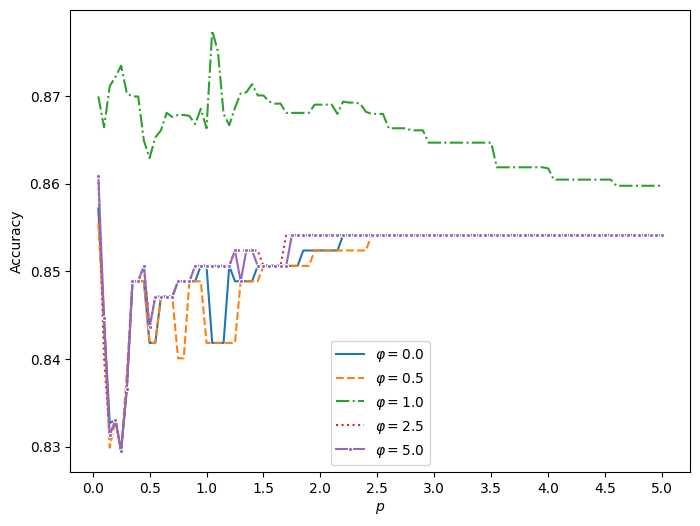

In [43]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = mean_accuracies[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = mean_accuracies[4,:], label = r'$\varphi = 5.0$', marker=".", ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
ax3.legend(loc='lower center')

# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

# Set specific x-axis tick labels
# ax.set_xticklabels(np.arange(0, 5.5, 0.5)

plt.show()

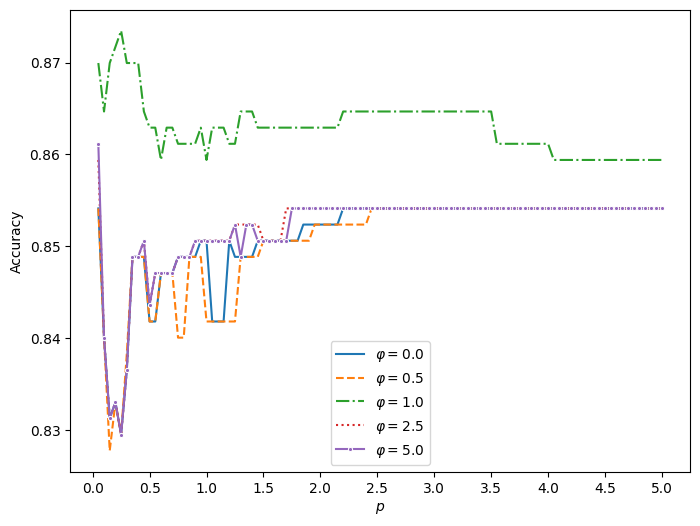

In [44]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = median_accuracies[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = median_accuracies[4,:], label = r'$\varphi = 5.0$', marker = '.', ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Accuracy')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
ax3.legend(loc='lower center')

# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

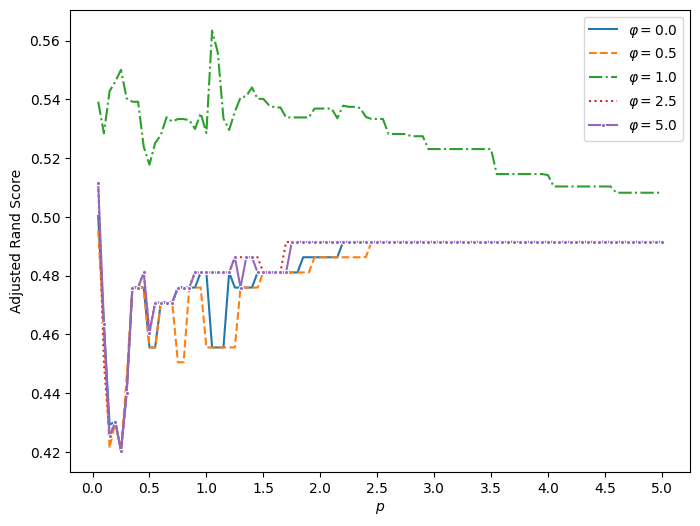

In [45]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = mean_adj_rand_scores[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = mean_adj_rand_scores[4,:], label = r'$\varphi = 5.0$', marker = '.', ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Adjusted Rand Score')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

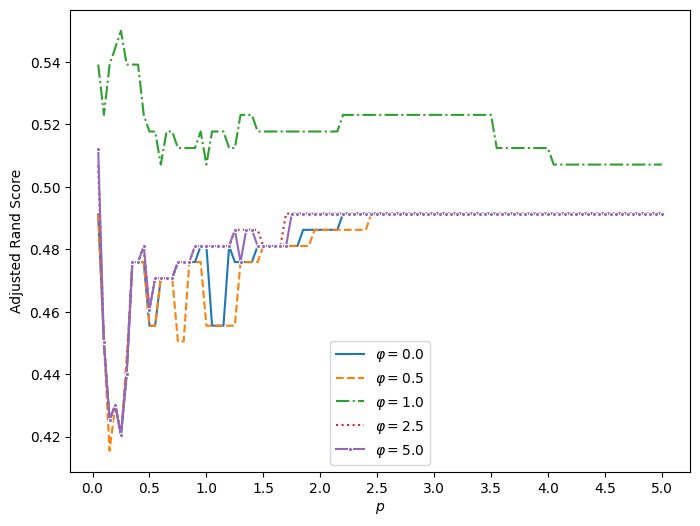

In [46]:
# Create the line plot of Accuracy

# Create a figure and axes
plt.figure(figsize=(8, 6))
ax3 = plt.gca() # Get the current axes

# Plot each curve individually
sns.lineplot(x = pvals, y = median_adj_rand_scores[0,:], label = r'$\varphi = 0.0$', ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[1,:], label = r'$\varphi = 0.5$', linestyle="--", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[2,:], label = r'$\varphi = 1.0$', linestyle="-.", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[3,:], label = r'$\varphi = 2.5$', linestyle=":", ax = ax3)
sns.lineplot(x = pvals, y = median_adj_rand_scores[4,:], label = r'$\varphi = 5.0$', marker = '.', ax = ax3)

# Add labels and title
ax3.set_xlabel(r'$p$')
ax3.set_ylabel('Adjusted Rand Score')
# ax3.set_title('Multiple Curves on a Single Seaborn Line Plot')
ax3.legend() # Display the legend for the labels
ax3.legend(loc='lower center')

# Set specific x-axis tick locations
ax3.set_xticks(np.arange(0, 5.5, 0.5))

plt.show()

In [47]:
# Code written by Abeeb A. Awotunde, Jun 2025, KFUPM
# Please reference the following paper(s) related to this code:
# The Joint Distance Measure: A Measure of Similarity Accounting for Spatial and Angular Distances
# Arabian Journal of Science and Engineering
#
max_values = ( np.max(mean_accuracies, axis = 1) )
print('max_values:', max_values)
max_mean_accuracies_all = []
max_indices_pvals_all = []
mmm = 0
for max_value in max_values:
  indices_of_max = np.where(mean_accuracies[mmm,:] == max_value)
  max_mean_accuracies = mean_accuracies[mmm][indices_of_max]
  max_indices_pvals = pvals[indices_of_max]
  #
  max_mean_accuracies_all.append(max_mean_accuracies)
  max_indices_pvals_all.append(max_indices_pvals)
  # print('indices_of_max', indices_of_max[0])
  # print('max_mean_accuracies:', max_mean_accuracies)
  # print('max_indices_pvals:', max_indices_pvals)
  mmm += 1

# df_max_mean_accuracies = pd.DataFrame(max_mean_accuracies_all, index = jdm_vphis, columns = ['max_mean_accuracies'])
df_max_mean_accuracies = pd.DataFrame(max_mean_accuracies_all, index = jdm_vphis)
display(df_max_mean_accuracies)
print()

df_max_indices_pvals = pd.DataFrame(max_indices_pvals_all, index = jdm_vphis)
display(df_max_indices_pvals)
print()

max_values: [0.85717633 0.85553603 0.87744581 0.86080844 0.8609256 ]


,0
0.0,0.857176
0.5,0.855536
1.0,0.877446
2.5,0.860808
5.0,0.860926


,0
0.0,0.05
0.5,0.05
1.0,1.05
2.5,0.05
5.0,0.05


In [48]:
print('mean_accuracies:\n', mean_accuracies)

mean_accuracies:
 [[0.85717633 0.84463972 0.83268893 0.83304042 0.82952548 0.83655536
  0.84885764 0.84885764 0.84885764 0.84182777 0.84182777 0.84710018
  0.84710018 0.84710018 0.84885764 0.84885764 0.84885764 0.84885764
  0.85061511 0.85061511 0.84182777 0.84182777 0.84182777 0.85061511
  0.84885764 0.84885764 0.84885764 0.84885764 0.85061511 0.85061511
  0.85061511 0.85061511 0.85061511 0.85061511 0.85061511 0.85061511
  0.85237258 0.85237258 0.85237258 0.85237258 0.85237258 0.85237258
  0.85237258 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.85413005 0.85413005 0.85413005 0.85413005
  0.85413005 0.85413005 0.8541